##### Importing libraries and data

In [142]:
library(data.table)
library(randomForest)
library(corrplot)
load("../projetdatascience.rda")

In [143]:
projetValid$target = NA #adding column target to rbind the train and the valid subset

In [144]:
projetTrain = rbind(projetTrain,projetValid)

##### getting the emptiness ratio and number of factors foreach column and save the information in dataframe

In [145]:
vec_names         = names(projetTrain)
nb_lignes         = nrow(projetTrain)
vec_taux          = rep(0,length(vec_names))
vec_factors       = rep(0,length(vec_names))
index             = 1
data.informations = data.table(
                         feature=vec_names, 
                         taux=vec_taux,
                         factors=vec_factors
                        )


for(name in data.informations$feature){
    data.informations[index,  taux := (sum( is.na(projetTrain[,name, with=FALSE])) / nb_lignes)*100] 
    data.informations[index,factors:= length(table(projetTrain[,name, with=FALSE]))]
    index=index+1
}

##### showing the emptiness ratio (>0) of columns

In [146]:
data.informations[taux>0]

,feature,taux,factors
1,Employment_Info_1,0.0319967666425288,1936
2,Employment_Info_4,11.4161095299843,871
3,Employment_Info_6,18.278573954632,992
4,Insurance_History_5,42.7678887186137,2265
5,Family_Hist_2,48.2578602583318,68
6,Family_Hist_3,57.6632256108856,90
7,Family_Hist_4,32.3066300668564,68
8,Family_Hist_5,70.4114110574089,90
9,Medical_History_1,14.9694346676546,171
10,Medical_History_10,99.061989525269,103


##### saving in vectors the columns to factorise

In [147]:
columnsToFactor = data.informations[factors<10]$feature

In [148]:
projetTrain = projetTrain[,target:=ifelse(target==1,"OK","KO")] # transforming target from 1 0 to OK and KO

##### factorisation of columns that contains less than 10 unique values

In [149]:
for (feature in columnsToFactor) {    
    projetTrain[,feature:=as.factor(get(feature)),with=FALSE]
}
projetTrain$Product_Info_2 = as.factor(projetTrain$Product_Info_2)

##### filling NA values

In [150]:
projetTrain = na.roughfix(projetTrain)

##### creating columns 

* split the column prodcut info 2 in columns to isolate the letter and the level wheter it's A B C or 1 2 3 etc .. 
* creates columns where there will be the log, the x², the exp of the numerical columns existing in the dataset
* multiplication of columns that works well together but before, we should check if they work well together. 


##### This operations splits the alphabetical from the numerical information contained in product_info_2

In [ ]:
projetTrain[,Product_Info_2_Quali  := gsub("[0-9]","",Product_Info_2)]
projetTrain[,Product_Info_2_Quanti := gsub("[A-Z]","",Product_Info_2)]

In [152]:
projetTrain$Product_Info_2_Quali  = as.factor(projetTrain$Product_Info_2_Quali)
projetTrain$Product_Info_2_Quanti = as.integer(projetTrain$Product_Info_2_Quanti) 

##### we're gonna save this dataset as a "basic" dataset to use for the machine learning

In [153]:
projetTrain.base = projetTrain

##### getting the information for each column if it's factor, num or int in our df "data.informations"

In [154]:
index = 1
for(name in data.informations$feature){
    data.informations[index,class := class(as.data.frame(projetTrain[,name,with=FALSE])[,name])]
    index=index+1
}

##### the following step will create 3 columns that will take numerical columns as arguments, and apply a x², and exp

we'll take the columns following this conditions :
* class numeric and integer
* make sure we don't use the columns that have 17% of NA values
* and drop the ID column

In [124]:
'%!in%' <- function(x,y)!('%in%'(x,y)) #CREATING NOT IN OPERATOR THAT RETURNS MASK 

numeric.columns         = data.informations[class=="numeric"]$feature
integer.columns         = data.informations[class=="integer"]$feature
todrop.columns          = c("Id",data.informations[taux > 17]$feature)

aggr.columns            = c(numeric.columns,integer.columns)
mask.of.columns.to.drop = aggr.columns %!in% todrop.columns #columns that are not in todrop.columns
final.columns           = aggr.columns[mask.of.columns.to.drop]

##### create the x²,and exp foreach column that is in final.columns

In [126]:
for(column in final.columns){
    projetTrain[,paste0(column,"_log") := log(get(column))]
    projetTrain[,paste0(column,"_²")   := get(column)^get(column)]
    projetTrain[,paste0(column,"exp")  := exp(get(column))]
}

##### checking the correlation between the numerical and integers columns

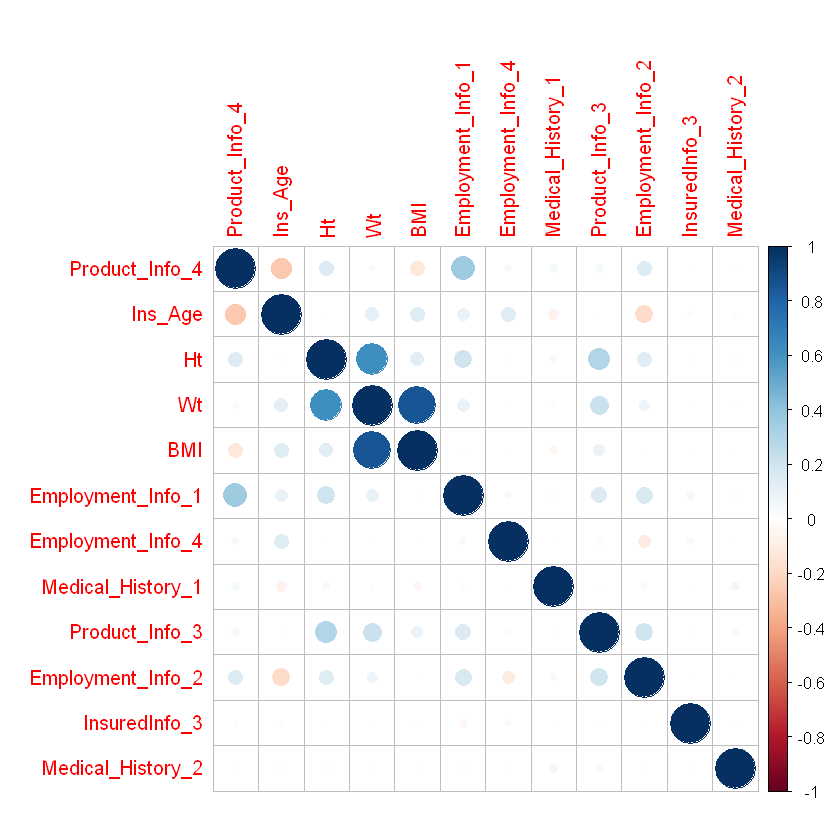

In [127]:
M = cor(projetTrain[,final.columns,with=FALSE])
corrplot(M, method = "circle")

##### now we're gonna create well correlated (>0.18) columns by multiplying or dividing values between them 

In [128]:
starting.point = 2 

for(i in seq(1,ncol(M))){
    
    if(starting.point < 13){ #loop meant to cover just the part under the diagonal of the matrix
        
            for(j in seq(starting.point,nrow(M))){
    
            if( abs(M[i,j]) > 0.18 ){ #if the correlation is above |0.18| we'll create a column that will multiply the correlated ones, and divide them by the correlation coefficient
                name.of.col.first  = final.columns[i]
                name.of.col.second = final.columns[j]
                coef.corr          = M[i,j]
                
                if( !(name.of.col.first =="Ht" && name.of.col.second=="Wt" ) &&
                    !(name.of.col.first=="Wt" && name.of.col.second=="BMI") ){ # We don't consider the relation between WT and BMI and Ht and Wt
                    
                    print(paste(name.of.col.first,name.of.col.second,"COEF CORR :",M[i,j]))
                    
                    first.vec        = projetTrain[,name.of.col.first,with=FALSE]
                    second.vec       = projetTrain[,name.of.col.second,with=FALSE]
                    
                    if( max(first.vec) <= 1 && max(second.vec) <= 1){
                        projetTrain[,paste0(name.of.col.first,"_",name.of.col.second)] = ( first.vec / second.vec ) / coef.corr
                    }
                    else{
                        projetTrain[,paste0(name.of.col.first,"_",name.of.col.second)] = ( first.vec * second.vec ) / coef.corr

                    }
                }
                
            }
        } 
        starting.point = starting.point+1
    }
}

[1] "Product_Info_4 Ins_Age COEF CORR : -0.26135598438449"
[1] "Product_Info_4 Employment_Info_1 COEF CORR : 0.350920626255596"
[1] "Ins_Age Employment_Info_2 COEF CORR : -0.188085945328153"
[1] "Ht Employment_Info_1 COEF CORR : 0.200462753627692"
[1] "Ht Product_Info_3 COEF CORR : 0.293546375794411"
[1] "Wt Product_Info_3 COEF CORR : 0.213546002814789"
[1] "Product_Info_3 Employment_Info_2 COEF CORR : 0.191770726317291"


##### replacing the infinte values by NA's ... 

In [130]:
for (j in 1:ncol(projetTrain)) set(projetTrain, which(is.infinite(projetTrain[[j]])), j, NA)

##### we're gonna drop the columns created that have too much NA values

In [ ]:
projetTrain$Employment_Info_4_log = NULL
projetTrain$Medical_History_2_²   = NULL

##### fixing the na values left 

In [134]:
projetTrain = na.roughfix(projetTrain)

##### splitting back the train and the validation test and write csv's

In [136]:
nb.rows.to.extract = nrow(projetTrain)-nrow(projetValid)

In [156]:
sub.projetTrain.base = projetTrain.base[1:nb.rows.to.extract]
sub.projetValid.base = projetTrain.base[(nb.rows.to.extract+1):nrow(projetTrain.base)]

In [157]:
write.csv(sub.projetTrain.base, file = "../data_processed/projetTrainBase.csv")
write.csv(sub.projetValid.base, file = "../data_processed/projetValidBase.csv")

In [139]:
sub.projetTrain = projetTrain[1:nb.rows.to.extract]
sub.projetValid = projetTrain[(nb.rows.to.extract+1):nrow(projetTrain)]

In [140]:
write.csv(sub.projetTrain, file = "../data_processed/projetTrainProcessed.csv")
write.csv(sub.projetValid, file = "../data_processed/projetValidProcessed.csv")

# GOOD TO GO 

#### Now we're done with the data processing, we will compare the results of the algorithms obtained with a "basic" data processing against this "more advanced" data processing 